# Create dataset

In [2]:
from PIL import Image
import glob
import os.path

base_dir = 'c:/tmp/' # images are expected to be in subfolders of this folder (no nested subfolders)
resized_suffix = '_resized'

size = (240, 240)
images = []
for filename in glob.glob(base_dir + '*/*.jpg'):
    if resized_suffix in filename: continue # make sure we don't process the files we already resized
    resized_filename = os.path.splitext(filename)[0] + resized_suffix + '.jpg'
    if not os.path.isfile(resized_filename):
        image = Image.open(filename)
        image.thumbnail(size, Image.ANTIALIAS)
        image.save(resized_filename, "JPEG")
    images.append(Image.open(resized_filename))

print("prepared " + str(len(images)) + " images")

prepared 3 images


# Extract Features

## HSV histogram

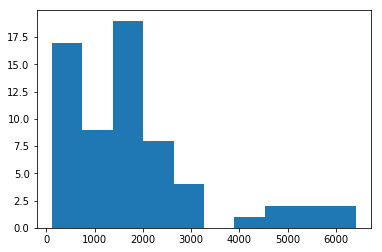

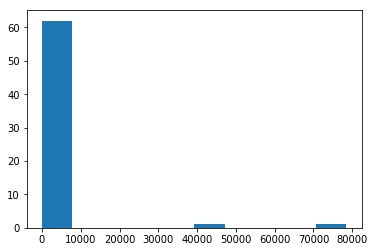

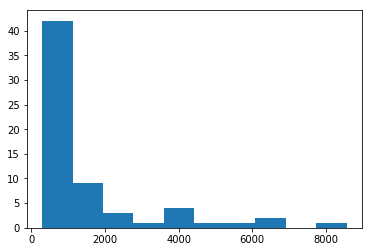

In [9]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

featrues = np.zeros(shape=(len(images), 64)) # initialize feature matrix

for i, image in enumerate(images):
    featrues[i] = np.histogram(image.convert('HSV'), bins=64)[0]
    plt.hist(featrues[i])
    plt.show()

## Edge histogram

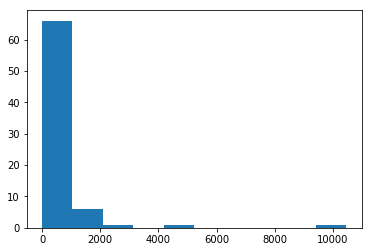

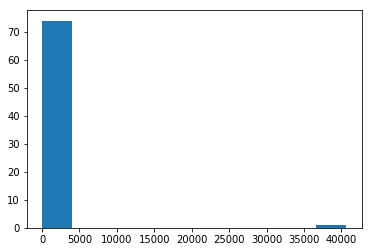

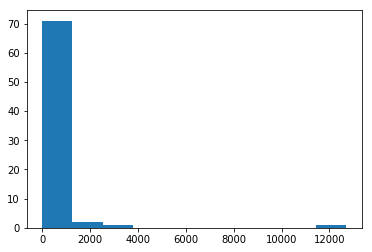

In [12]:
from skimage.filters import sobel

featrues = np.zeros(shape=(len(images), 75)) # initialize feature matrix

for i, image in enumerate(images):
    edges = sobel(image.convert('HSV').getchannel('V'))
    plt.figure()
    featrues[i] = np.histogram(edges, bins=75)[0]
    plt.hist(featrues[i]) # TODO how am i supposed to do that edge histogram thing?


# K-means clustering

0
1
0


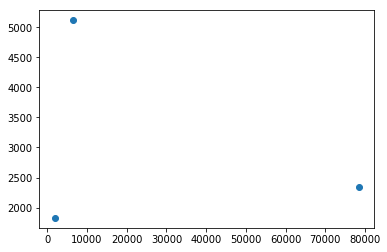

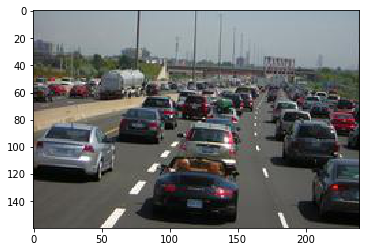

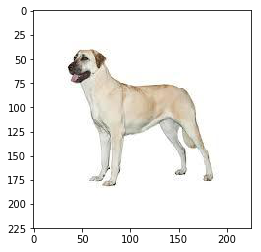

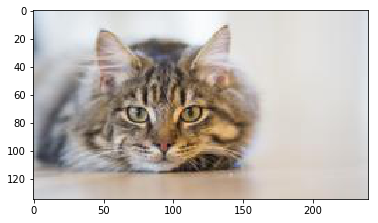

In [49]:
from sklearn.cluster import KMeans

plt.scatter(X[:,0], X[:,1])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

for i, img in enumerate(images):
    plt.figure()
    plt.imshow(images[i])
    print(kmeans.labels_[i])
#kmeans.labels_
#kmeans.cluster_centers_


